In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

%matplotlib inline
from IPython import display


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch


from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from tqdm import tqdm

import os

/tmp/ipykernel_52658/254083166.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-03-14 09:26:58.781716: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-14 09:26:58.815467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-14 09:26:

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)

CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
import tifffile as tiff
import glob
import re
import datetime

In [4]:
patch=99
imgs = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/*/*_patch_'+str(patch)+'.tif')
filenames=glob.glob('/cloud/s2_europa_test/ROIs1868/142/S2/*/*_patch_'+str(patch)+'.tif')


In [5]:

dates=[]
for file in filenames:
    tmp=re.search(r'\d{4}-\d{2}-\d{2}', file)
    dates.append(tmp[0])

sort_dates=sorted(dates, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))

#Get sorting indices
sort_ind_dates=[]
for date in sort_dates:
    sort_ind_dates.append(dates.index(date))

#Sort images according to date
imgs_sort=imgs[sort_ind_dates,:,:,:]

#Sort file names
filenames_sort=[]
for sort_ind in sort_ind_dates:
    filenames_sort.append(filenames[sort_ind]) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


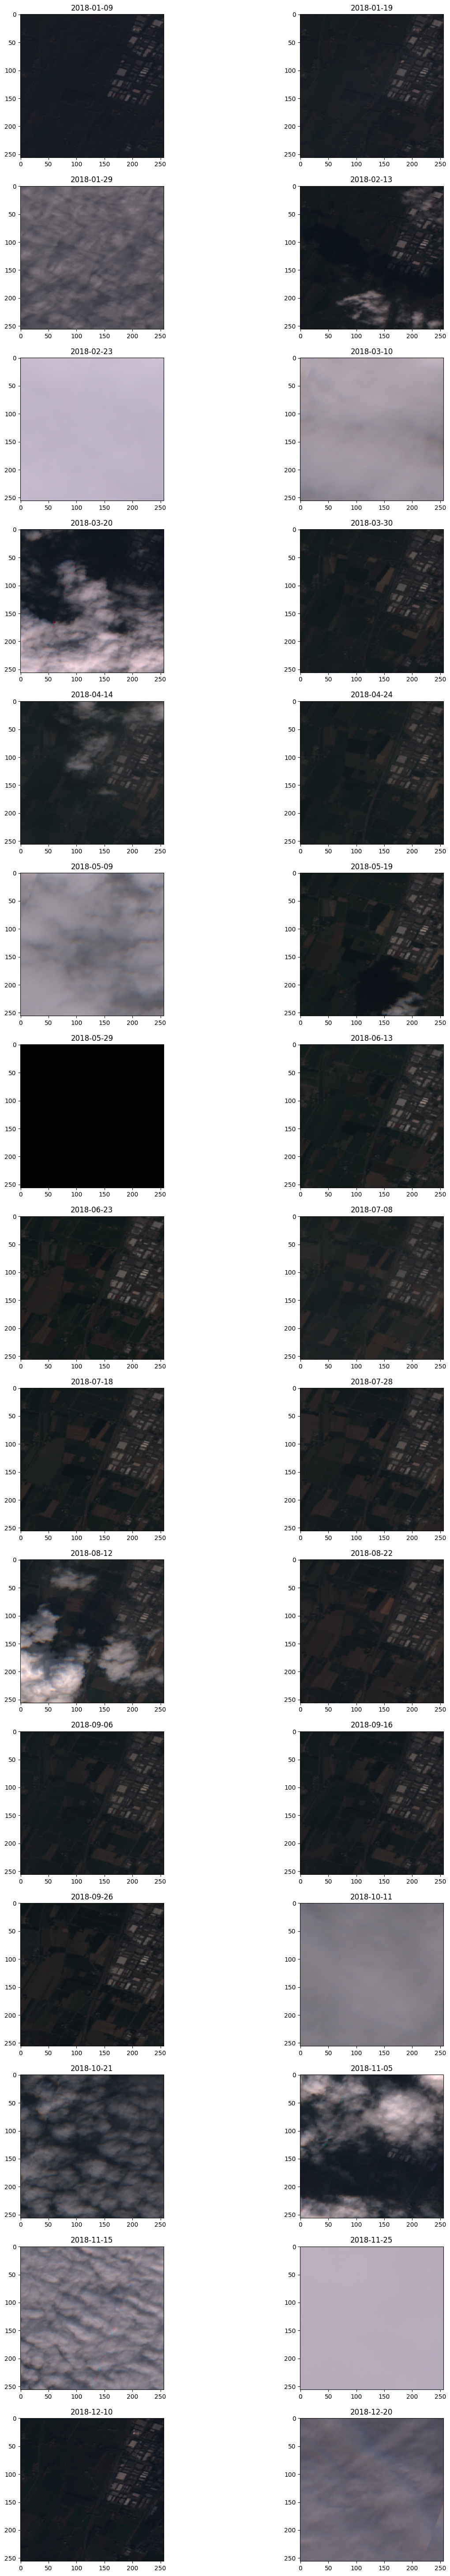

In [6]:
nrows=15
ncols=2
plt.rcParams["figure.figsize"] = [15, 5*nrows]
fig, axs =plt.subplots(nrows=nrows,ncols=ncols)
for i,ax in enumerate(axs.ravel()):
    im=imgs_sort[i,:,:,:]
    ax.imshow(im[:,:,[3,2,1]]/10000)
    ax.set_title(sort_dates[i])

In [7]:
filenames_sort

['/cloud/s2_europa_test/ROIs1868/142/S2/0/s2_ROIs1868_142_ImgNo_0_2018-01-09_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/1/s2_ROIs1868_142_ImgNo_1_2018-01-19_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/2/s2_ROIs1868_142_ImgNo_2_2018-01-29_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/3/s2_ROIs1868_142_ImgNo_3_2018-02-13_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/4/s2_ROIs1868_142_ImgNo_4_2018-02-23_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/5/s2_ROIs1868_142_ImgNo_5_2018-03-10_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/6/s2_ROIs1868_142_ImgNo_6_2018-03-20_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/7/s2_ROIs1868_142_ImgNo_7_2018-03-30_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/8/s2_ROIs1868_142_ImgNo_8_2018-04-14_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/9/s2_ROIs1868_142_ImgNo_9_2018-04-24_patch_99.tif',
 '/cloud/s2_europa_test/ROIs1868/142/S2/10/s2_ROIs1868_142_ImgNo_10_2018-05-09_p

In [8]:
img = tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/8/s2_ROIs1868_142_ImgNo_8_2018-04-14_patch_99.tif')
img_pair_clear=tiff.imread('/cloud/s2_europa_test/ROIs1868/142/S2/9/s2_ROIs1868_142_ImgNo_9_2018-04-24_patch_99.tif')
img=img/10000
img_pair_clear=img_pair_clear/10000


In [9]:
np.shape(img)

(256, 256, 13)

Text(0.5, 1.0, 'Example image with RGB channel (4,3,2)')

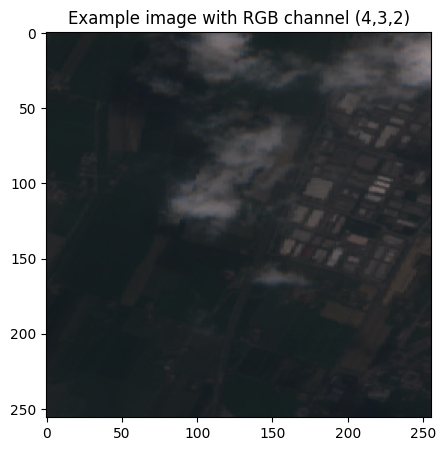

In [10]:
plt.rcParams["figure.figsize"] = [5, 5]
plt.imshow(img[:,:,[3,2,1]])
plt.title("Example image with RGB channel (4,3,2)")

In [11]:
img_11=img[:,:,11]
img_11_flat=np.array([j for sub in img_11 for j in sub])

Text(0.5, 1.0, 'Example image with band 11')

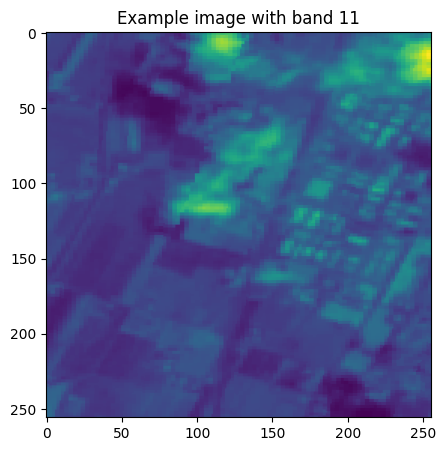

In [12]:
plt.imshow(img[:,:,11])
plt.title("Example image with band 11")

In [13]:
main_filepath='pytorch_models/cont_test'
n_ensemble=5
models=[]
for i in range(n_ensemble):
    models.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

X_test=pd.read_csv(main_filepath+'/xtest.csv',index_col=0)
y_test=pd.read_csv(main_filepath+'/ytest.csv',index_col=0)

In [14]:
#Reshape input image to correct form
img_12_bands=img[:,:,1:]
image_shape=np.shape(img_12_bands)
image_input=np.reshape(img_12_bands,(image_shape[0]*image_shape[1],image_shape[2]))

#Predict
for i,model in enumerate(models):
    if i==0:
        y_pred=model.predict(image_input)
    else:   
        y_pred=y_pred+model.predict(image_input)
y_pred=y_pred/len(models)

img_pred=y_pred[:,:,4] # Get median quantile

#Reshape output prediction
img_pred_reshape=np.reshape(img_pred,(image_shape[0],image_shape[1],image_shape[2]))


Text(0.5, 1.0, 'Example reconstruction band 11')

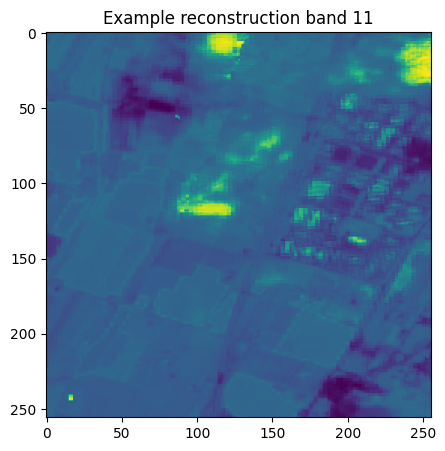

In [15]:
plt.imshow(img_pred_reshape[:,:,10])
plt.title("Example reconstruction band 11")

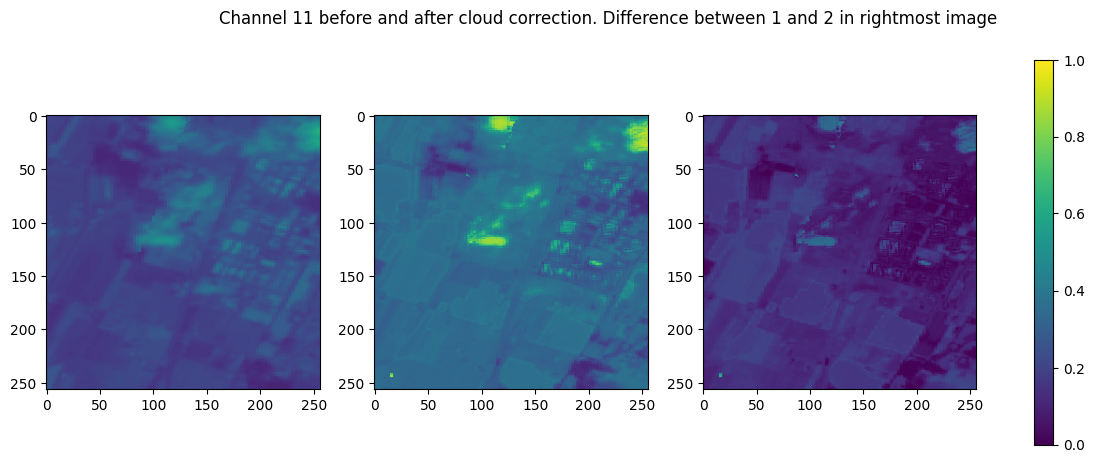

In [16]:
plt.rcParams["figure.figsize"] = [15, 5]
fig, axs =plt.subplots(nrows=1,ncols=3)
fig.suptitle("Channel 11 before and after cloud correction. Difference between 1 and 2 in rightmost image")

im1=axs[0].imshow(img[:,:,11],vmin=0,vmax=1)
im2=axs[1].imshow(img_pred_reshape[:,:,10],vmin=0,vmax=1)
im3=axs[2].imshow(np.abs((img[:,:,11])-(img_pred_reshape[:,:,10])),vmin=0,vmax=1)
fig.colorbar(im1,ax=axs.ravel().tolist())



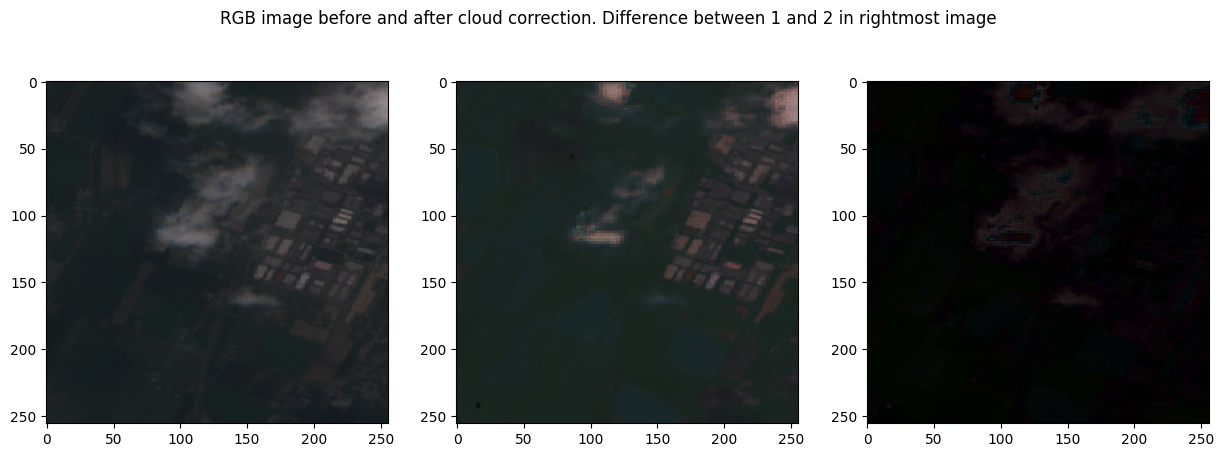

In [17]:
fig, axs =plt.subplots(nrows=1,ncols=3)
fig.suptitle("RGB image before and after cloud correction. Difference between 1 and 2 in rightmost image")

axs[0].imshow(img[:,:,[3,2,1]])
axs[1].imshow(img_pred_reshape[:,:,[2,1,0]])
axs[2].imshow(np.abs((img[:,:,[3,2,1]])-(img_pred_reshape[:,:,[2,1,0]])))

In [18]:
#Get quantiles of prediction

pred_quant_01=y_pred[:,:,0]
pred_quant_09=y_pred[:,:,-1]

img_pred_01=np.reshape(pred_quant_01,(image_shape[0],image_shape[1],image_shape[2]))
img_pred_09=np.reshape(pred_quant_09,(image_shape[0],image_shape[1],image_shape[2]))
# Get uncertainty image
pred_uncertainty=img_pred_09-img_pred_01

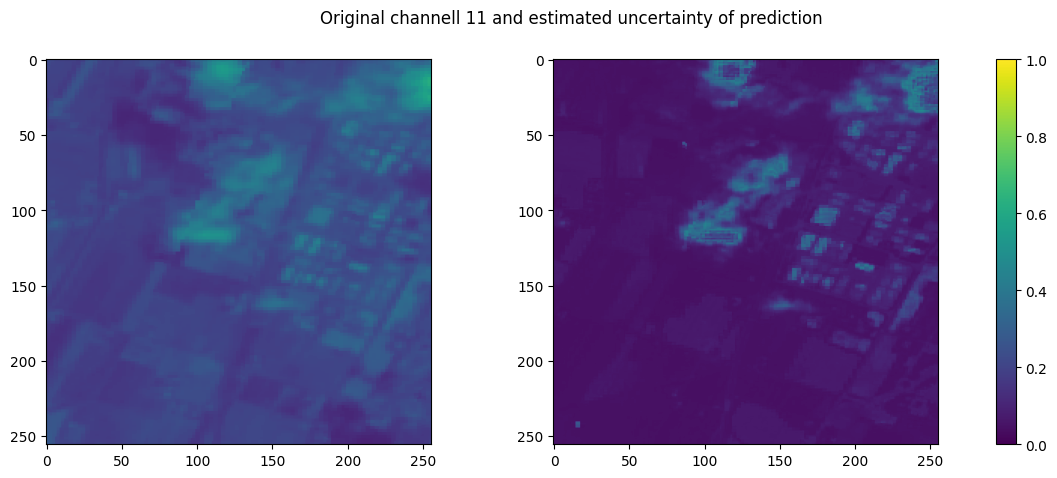

In [19]:
fig,axs=plt.subplots(nrows=1,ncols=2)
fig.suptitle("Original channell 11 and estimated uncertainty of prediction")
im1=axs[0].imshow(img[:,:,11],vmin=0,vmax=1)
axs[1].imshow(pred_uncertainty[:,:,10],vmin=0,vmax=1)
fig.colorbar(im1,ax=axs.ravel().tolist())

### Comparison "ground truth"

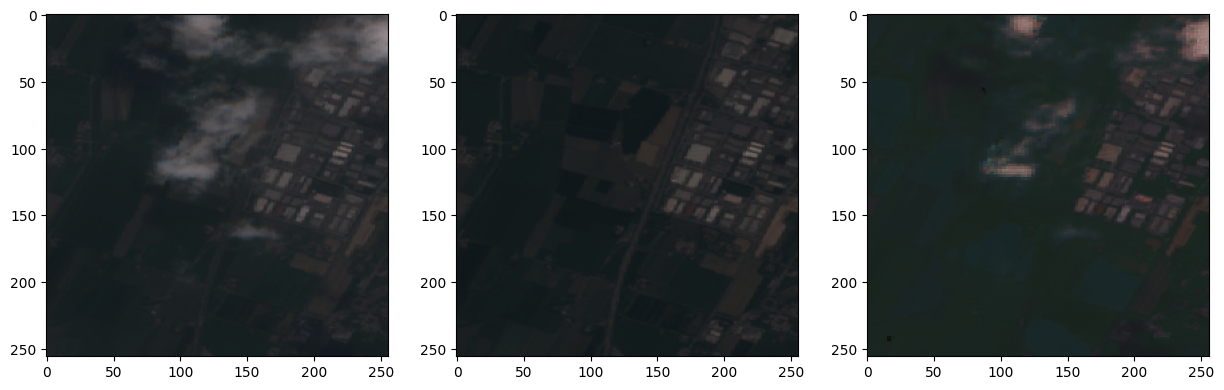

In [20]:
plt.rcParams["figure.figsize"] = [15, 5]
fig, axs = plt.subplots(nrows=1,ncols=3)
axs[0].imshow(img[:,:,[3,2,1]])
axs[1].imshow(img_pair_clear[:,:,[3,2,1]])
axs[2].imshow(img_pred_reshape[:,:,[2,1,0]])

In [21]:
MSE_og=np.sum(np.sum(np.square(img_pair_clear[:,:,1:]-img[:,:,1:]),axis=0),axis=0)
MSE_pred=np.sum(np.sum(np.square(img_pair_clear[:,:,1:]-img_pred_reshape),axis=0),axis=0)

In [22]:
for i in range(len(MSE_og)):
    if i<=6:
        print('MSE before corrrection, Band '+str(i+2)+': '+str(MSE_og[i]))
        print('MSE after corrrection, Band '+str(i+2)+': '+str(MSE_pred[i]))
    elif i==7:
        print('MSE before corrrection, Band '+str(i+1)+'A: '+str(MSE_og[i]))
        print('MSE after corrrection, Band '+str(i+1)+'A: '+str(MSE_pred[i]))
    else:
        print('MSE before corrrection, Band '+str(i+1)+': '+str(MSE_og[i]))
        print('MSE after corrrection, Band '+str(i+1)+': '+str(MSE_pred[i]))    

    print(' ')

MSE before corrrection, Band 2: 258.4043130700001
MSE after corrrection, Band 2: 112.12148739077662
 
MSE before corrrection, Band 3: 238.04058775999997
MSE after corrrection, Band 3: 158.01147159981164
 
MSE before corrrection, Band 4: 298.06581574000006
MSE after corrrection, Band 4: 193.6812464195437
 
MSE before corrrection, Band 5: 289.36284284
MSE after corrrection, Band 5: 334.97929181000467
 
MSE before corrrection, Band 6: 287.15913457000005
MSE after corrrection, Band 6: 1070.9753958535582
 
MSE before corrrection, Band 7: 309.93149076999987
MSE after corrrection, Band 7: 1360.9694173345335
 
MSE before corrrection, Band 8: 299.7659777100001
MSE after corrrection, Band 8: 863.2116408717891
 
MSE before corrrection, Band 8A: 318.62669030999996
MSE after corrrection, Band 8A: 1616.6743590080862
 
MSE before corrrection, Band 9: 79.41137552999997
MSE after corrrection, Band 9: 26.93031280787433
 
MSE before corrrection, Band 10: 20.230641289999994
MSE after corrrection, Band 10:

In [23]:
energy_gt=np.sum(np.sum(np.square(img_pair_clear[:,:,1:]),axis=0),axis=0)

In [24]:
#np.linal.norm() -> Frobenius norm i.e root of the sum of squares
norm_og=np.linalg.norm(np.square(img_pair_clear[:,:,1:]-img[:,:,1:]),axis=(0,1))**2
norm_pred=np.linalg.norm(np.square(img_pair_clear[:,:,1:]-img_pred_reshape),axis=(0,1))**2
norm_gt=np.linalg.norm(np.square(img_pair_clear[:,:,1:]),axis=(0,1))**2

NMSE_og=norm_og/norm_gt
NMSE_pred=norm_pred/norm_gt

In [25]:
for i in range(len(MSE_og)):
    if i<=6:
        print('NMSE before corrrection, Band '+str(i+2)+': '+str(NMSE_og[i]))
        print('NMSE after corrrection, Band '+str(i+2)+': '+str(NMSE_pred[i]))
    elif i==7:
        print('NMSE before corrrection, Band '+str(i+1)+'A: '+str(NMSE_og[i]))
        print('NMSE after corrrection, Band '+str(i+1)+'A: '+str(NMSE_pred[i]))
    else:
        print('NMSE before corrrection, Band '+str(i+1)+': '+str(NMSE_og[i]))
        print('NMSE after corrrection, Band '+str(i+1)+': '+str(NMSE_pred[i]))    

    print(' ')

NMSE before corrrection, Band 2: 0.40916655532605556
NMSE after corrrection, Band 2: 0.1513406269469289
 
NMSE before corrrection, Band 3: 0.38147552739872453
NMSE after corrrection, Band 3: 0.20992590362258
 
NMSE before corrrection, Band 4: 0.6559047243121662
NMSE after corrrection, Band 4: 0.7886964033005239
 
NMSE before corrrection, Band 5: 0.40644409095452166
NMSE after corrrection, Band 5: 0.49534364423738064
 
NMSE before corrrection, Band 6: 0.03139431942272221
NMSE after corrrection, Band 6: 0.16690215658791144
 
NMSE before corrrection, Band 7: 0.014278237056890861
NMSE after corrrection, Band 7: 0.12971308779296048
 
NMSE before corrrection, Band 8: 0.01511295992231833
NMSE after corrrection, Band 8: 0.05937576905485766
 
NMSE before corrrection, Band 8A: 0.011187768040931072
NMSE after corrrection, Band 8A: 0.1462465877663444
 
NMSE before corrrection, Band 9: 0.1735363322201054
NMSE after corrrection, Band 9: 0.02066758426230545
 
NMSE before corrrection, Band 10: 147.267

## Load COT estimator

In [27]:
from cot_train.utils import StatCollector, MLP5, mlp_inference

In [28]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [29]:
SKIP_BAND_1=1
PROPERTY_COLUMN_MAPPING = {'spec_bands': [i for i in range(1 + SKIP_BAND_1, 14)], 'angles': [14, 15, 16], 'thick': [17], 'type': [18], 'prof_id': [19], 'gas_vapour': [20, 21], 'surf_prof': [22]}
INPUTS = ['spec_bands']
REGRESSOR = 'thick'

input_dim = np.sum([len(PROPERTY_COLUMN_MAPPING[inp]) for inp in INPUTS])
output_dim = 1

model_load_paths=['smhi_models/2023-08-10_10-33-44/model_it_2000000','smhi_models/2023-08-10_10-34-06/model_it_2000000',
                    'smhi_models/2023-08-10_10-34-18/model_it_2000000','smhi_models/2023-08-10_10-34-28/model_it_2000000',
                    'smhi_models/2023-08-10_10-34-46/model_it_2000000','smhi_models/2023-08-10_10-34-58/model_it_2000000',
                    'smhi_models/2023-08-10_10-35-09/model_it_2000000','smhi_models/2023-08-10_10-35-31/model_it_2000000',
                    'smhi_models/2023-08-10_10-35-52/model_it_2000000','smhi_models/2023-08-10_10-36-12/model_it_2000000']

#model_load_paths=['cot_train/log/2024-03-14_09-11-39/model_it_2000000']

models_cot=[]
for model_path in model_load_paths:
    model_cot = MLP5(input_dim, output_dim, apply_relu=True)
    model_cot.load_state_dict(torch.load(model_path, map_location=device))
    model_cot.to(device)
    models_cot.append(model_cot)

In [30]:
means_input_train = np.mean(image_input, axis=0)
stds_input_train = np.std(image_input, axis=0)
inputs = (image_input - means_input_train) / stds_input_train


image_input_tens=torch.Tensor(inputs).to(device)
#image_pred_cot=model_cot(image_input_tens).cpu().data.numpy()*50

preds = 0
for model_cot in models_cot:
    curr_preds=model_cot(image_input_tens)/len(models_cot)
    preds=preds+curr_preds

image_pred_cot=preds.cpu().data.numpy()*50 #unnormalise

In [31]:
image_pred_cot_reshape=np.reshape(image_pred_cot,(image_shape[0],image_shape[1]))
image_pred_cot_reshape_thresh=image_pred_cot_reshape.copy()

clear=0.5
thin=3.6
image_pred_cot_reshape_thresh[image_pred_cot_reshape_thresh<=clear]=0 # Clear
image_pred_cot_reshape_thresh[(image_pred_cot_reshape_thresh<=thin)&(image_pred_cot_reshape_thresh>clear)]=1 # Thin cloud
image_pred_cot_reshape_thresh[image_pred_cot_reshape_thresh>thin]=2 # Thick cloud

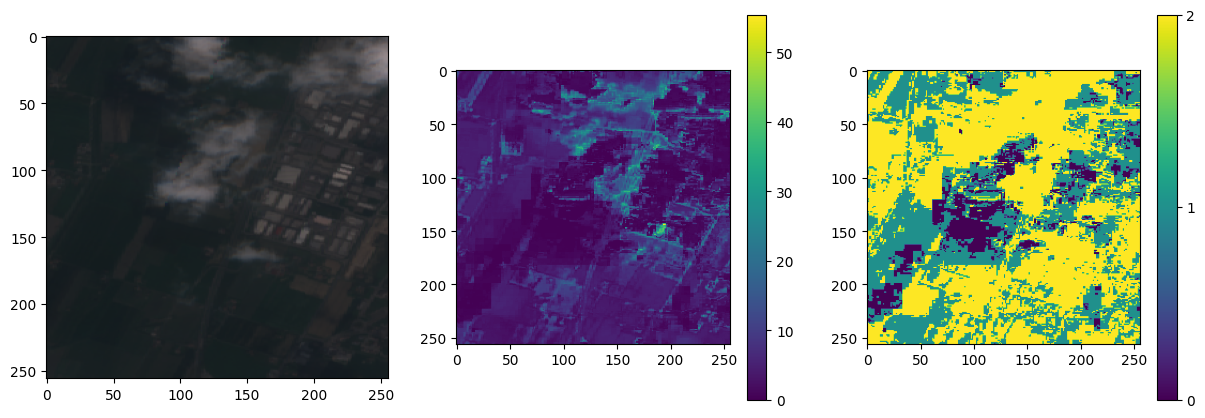

In [34]:
fig,axs=plt.subplots(nrows=1,ncols=3)
axs[0].imshow(img[:,:,[3,2,1]])
im=axs[1].imshow(image_pred_cot_reshape)
im2=axs[2].imshow(image_pred_cot_reshape_thresh,vmin=0,vmax=2)
fig.colorbar(im,ax=axs[1])
fig.colorbar(im2,ticks=[0,1,2],ax=axs[2])

In [33]:
THRESHOLD_THICKNESS_IS_CLOUD = [0.025]
THRESHOLD_THICKNESS_IS_THIN_CLOUD = [0.015]
MLP_POST_FILTER_SZ = 1 #1 no filter, >=2 majority vote within that-sized square

pred_map, pred_map_binary_list, pred_map_binary_thin_list = mlp_inference(img[:,:,1:], torch.Tensor(means_input_train).to(device), 
                                                                          torch.Tensor(stds_input_train).to(device), models_cot, 
                                                                          batch_size=32, device=device,
                                                                          thresh_cloud=THRESHOLD_THICKNESS_IS_CLOUD,
                                                                          thresh_thin_cloud=THRESHOLD_THICKNESS_IS_THIN_CLOUD,
                                                                          post_filt_sz=MLP_POST_FILTER_SZ)

## Test our COT etimation

In [82]:
main_filepath='pytorch_models/our_cot_est'
n_ensemble=5
models_cot_our=[]
for i in range(n_ensemble):
    models_cot_our.append(torch.load(main_filepath+'/model'+str(i)+'/model_file'))

In [83]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [84]:
image_input_tens=torch.Tensor(image_input).to(device)
preds = 0
for model_cot in models_cot_our:
    curr_preds=model_cot.model(image_input_tens)
    preds=preds+curr_preds
preds=preds.cpu().data.numpy()/len(models_cot_our)
preds=preds[:,0,:]

In [85]:
preds

array([[0.05291821, 0.18985441, 0.31494778],
       [0.05291821, 0.18985441, 0.31494778],
       [0.04722378, 0.18423623, 0.30932936],
       ...,
       [0.00124229, 0.13492823, 0.25714985],
       [0.00791223, 0.13874607, 0.25880924],
       [0.01051034, 0.14155996, 0.26177162]], dtype=float32)

In [86]:
preds_cot_reshape=np.reshape(preds[:,1],(image_shape[0],image_shape[1]))

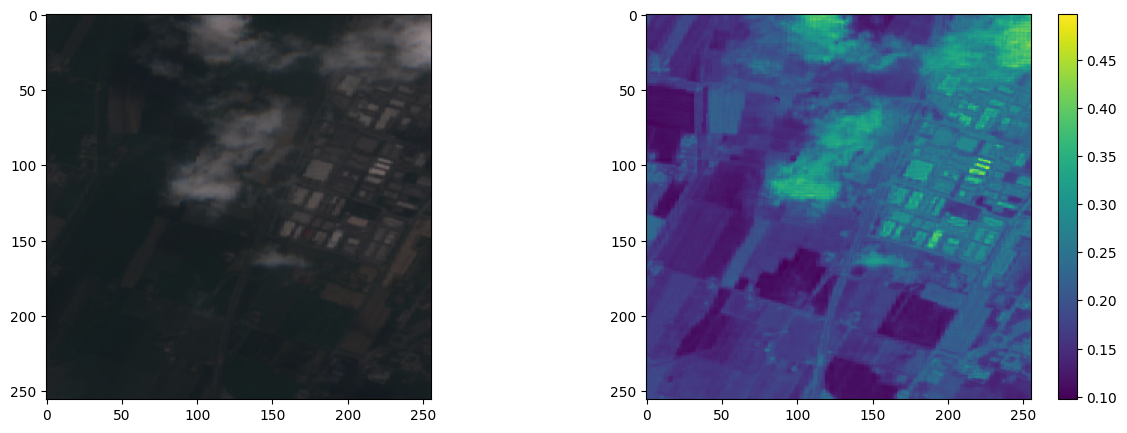

In [87]:
fig,axs=plt.subplots(nrows=1,ncols=2)
axs[0].imshow(img[:,:,[3,2,1]])
im=axs[1].imshow(preds_cot_reshape)
fig.colorbar(im,ax=axs[1])